# Demo de implementación de un algoritmo de Colonia de Abejas (Bee Algorithm) para resolver el problema de encontrar un Máximo Óptimo  definido al azar en un plano y tratando de esquivar  los máximos locales aleatorios


1) Importar librerías:

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import operator
print("\nLibrerías importadas")


Librerías importadas


2) Establecer parámetros generales de la Corrida:

In [2]:
# Cantidad de Máximos Locales
CANT_MAXIMOS_LOCALES = 3

# Espacio mínimo y máximp del espacio de búsqueda
MIN_ESPACIO_BUSQ = -1000
MAX_ESPACIO_BUSQ = 1000

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 100

# Cantidades para  Abejas Exploradoras
CANT_ABEJAS_EXPLORADORAS = 5
CANT_MEJORES_ABEJAS_RECLUTAN = 5
CANT_ABEJAS_OBRERAS_RECL_ELITE = 2
CANT_ABEJAS_OBRERAS_RECL_NORMAL = 1

#  Área de las Abejas Exploradoras
RADIO_AREA_EXPLORADORA = 50
PORC_RED_AREA_EXPLORADORA = 0.5
MIN_RADIO_AREA_EXPLORADORA = 2

# Indica si se muestra el detalle de cada ciclo
MUESTRA_DETALLE = True

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


3) Especificar el objeto Abeja y la Función Heurística:

In [11]:
### clase MAPA DE BÚSQUEDA

class MapaBusqueda(object):

    def __init__(self, limMin, limMax, cantMaximosLocales=0):
          self.limMin = limMin
          self.limMax = limMax
          self.cantMax = cantMaximosLocales
          self.generarPosicionesRnd()

    def generarPosicionesRnd(self):
      
        # Define Posiciones Random para Máximos Locales y Óptimos
        # con Heurística también al Azar (entre 1 y 100)
        # controla que el máximo local/global no se ubique en la misma posición que el Hormiguero
        self.MaximosPos = []
        self.MaximosVal = []
        self.MaxOptimoID = 0
        auxMejorVal = -99
        i = 0
        while len(self.MaximosPos)<(self.cantMax+1):

            auxPos = [ random.randint(self.limMin, self.limMax),  random.randint(self.limMin, self.limMax) ]        
            auxVal = random.randint(-20, 100)

            self.MaximosPos.append( auxPos )
            self.MaximosVal.append( auxVal )
            
            if self.MaximosVal[self.MaxOptimoID] < auxVal:
                self.MaxOptimoID = i
            i= i + 1

        return True
   
    def printInformacion(self):
        # Muestra la información sobre el Mapa de Búsqueda
        print("\n** Máximos Generados: ", len(self.MaximosPos))
        for auxPos, auxVal in zip(self.MaximosPos, self.MaximosVal):
            print("  -->", auxPos, "{ ", auxVal, " } ")
        print("\n** Posición Máximo Óptimo: ", self.MaximosPos[self.MaxOptimoID], " { ",  self.MaximosVal[self.MaxOptimoID]," } **")
        print("\n")

    @property
    def posMaximos(self):
        return self.MaximosPos    

    @property
    def valMaximos(self):
        return self.MaximosVal   
        
    @property
    def posMaximoGlobal(self):
        return self.MaximosPos[self.MaxOptimoID]         
    
    @property
    def valMaximoGlobal(self):
        return self.MaximosVal[self.MaxOptimoID]  

    def estaEnMaximo(self, posicion):
      # Indica si la posición corresponde o no a un Máximo 
      # si es verdadero devuelve el valor correspondiente, sino 0
      for i in range(len(self.MaximosPos)):
        if posicion==self.MaximosPos[i]:
          return self.MaximosVal[i]
      return 0

    def funcHeuristica(self, posicion):
        # Define la Función Heurística para evaluar una posicion del mapa
        devuelve = 0
        disPosMenor = self.limMax
        for posMax, valMax in zip(self.MaximosPos, self.MaximosVal):

              # calcula la distancia al punto de la Particula
              sqerrors = ((x - y)**2 for x, y in zip(posicion, posMax))
              distPos =  math.fsum(sqerrors)**0.5 / 10
              
              # Si es la menor distancia calcula la Heurística
              if disPosMenor > distPos:
                  disPosMenor = distPos 
                  devuelve = ( valMax - distPos) 

          # Por las dudas controla que devuelva un valor positivo
        return max(devuelve,0)


print("\nClase Mapa de Búqueda definida") 


Clase Mapa de Búqueda definida


In [15]:
### clase ABEJA

class Abeja(object):
    
    def __init__(self, mapa=None, radioArea=0):
        
        if mapa == None:
            self.pos = []
            self.radio = 0
            self.valor = -9999
        else:        
            self.pos = [random.randint(mapa.limMin, mapa.limMax) for _ in range(2)]
            self.valor = mapa.funcHeuristica(self.pos)
            self.radio = radioArea

    def _reset(self):
        self.pos = []
        self.radio = 0
        self.valor = -9999

    @property
    def heuristica(self):
        return self.valor

    @property
    def posicion(self):
        return self.pos    

    @property
    def tieneArea(self):
        return self.radio>0 

    def reclutarObreras(self, mapa, cantObrerasReclutadas, \
                        radioAreaExpl=RADIO_AREA_EXPLORADORA, porcRedAreaExpl = PORC_RED_AREA_EXPLORADORA, minAreaExpl=MIN_RADIO_AREA_EXPLORADORA):
        
        # Si el radio del área es nulo, no se generan
        if self.radio <= 0:
            return []

        obrerasReclutadasNuevas = []
        algunaObreraMejor = False
        for i in range(cantObrerasReclutadas):

              # Crea una nueva abeja a la que le asigna una posción relativa a la exploradora padre
              # y luego calcula su herística
              nOb = Abeja()
              for i in range(len(self.pos)):
                  nOb.pos.append( random.randint(int(self.pos[i]-self.radio), int(self.pos[i]+self.radio)) )
              nOb.valor = mapa.funcHeuristica(nOb.pos)
              
              if nOb.valor > self.valor:
                  # si la nueva obra es mejor que la padre, 
                  #    pasa a ser una exploradora
                  nOb.radio = radioAreaExpl
                  algunaObreraMejor = True

              obrerasReclutadasNuevas.append( nOb )
        
        if not algunaObreraMejor:
                # Cuando ninguna obrera es mejor, 
                #     se reduce el área de la abeja exploradora 
                self.radio = self.radio * (1-porcRedAreaExpl)
                if self.radio <= minAreaExpl:
                    self.radio = 0

        return obrerasReclutadasNuevas

    def hacerExploradoraArea(self, radioArea):
        self.radio = radioArea
        return self.radioArea

print("\nClase Abeja definida")


Clase Abeja definida


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [16]:
## INICIALIZA EL MAPA DE BÚSQUEDA

# Define el Mapa de Búsqueda
mapa = MapaBusqueda(limMin=MIN_ESPACIO_BUSQ, limMax=MAX_ESPACIO_BUSQ, \
                    cantMaximosLocales=CANT_MAXIMOS_LOCALES)

# Muestra su información
mapa.printInformacion()


** Máximos Generados:  4
  --> [-195, 194] {  42  } 
  --> [-782, 530] {  -9  } 
  --> [-441, -951] {  87  } 
  --> [628, 486] {  14  } 

** Posición Máximo Óptimo:  [-441, -951]  {  87  } **




In [17]:
## EJECUCIÓN DE LA CORRIDA

# vectores auxiliares 
ciclo = 1    
mejorAbeja = None
mejorAbejaCorrida = None
ciclosAbejas = []
ciclosMaxAptitud = []
beePobla = []

# Define las abejas exploradoras iniciales
for i in range(CANT_ABEJAS_EXPLORADORAS):
  b = Abeja(mapa, radioArea=RADIO_AREA_EXPLORADORA)
  beePobla.append( b ) 
  ciclosAbejas.append( b.posicion )

while ciclo < CANT_CICLOS:

    if MUESTRA_DETALLE:
        print("\n-- Ciclo  %i --" % ciclo)    
        print("  Cantidad de Abejas: ", len(beePobla) ) 

    # Evalúa las abejas exploradoras de la población para determinar las mejores con área disponible
    rankingAbejas = sorted([b for b in beePobla if b.tieneArea], key=operator.attrgetter('heuristica'), reverse=True)
    mejorAbeja = rankingAbejas[0]
    if mejorAbejaCorrida == None or mejorAbeja.heuristica > mejorAbejaCorrida.heuristica:
        mejorAbejaCorrida = mejorAbeja
    ciclosMaxAptitud.append( rankingAbejas[0].heuristica )

    # Realiza la reclutación de las abejas
    # pero  solo de las 'CANT_MEJORES_ABEJAS_RECLUTAN' mejores
    reclObreras = []
    for exBee in rankingAbejas[:CANT_MEJORES_ABEJAS_RECLUTAN]:
          # Recluta las abejas obreras (cantidad elite para la mejor, normal el resto)
          if exBee == mejorAbeja:
              reclObreras = exBee.reclutarObreras(mapa, CANT_ABEJAS_OBRERAS_RECL_ELITE)
          else:
              reclObreras = exBee.reclutarObreras(mapa, CANT_ABEJAS_OBRERAS_RECL_NORMAL)

          # Agrega las nuevas abejas reclutadas
          beePobla.extend( reclObreras )
          ciclosAbejas.extend([b.posicion for b in reclObreras])

    if MUESTRA_DETALLE:
        print("  Mejor Abeja:", mejorAbeja.posicion, " { ", mejorAbeja.heuristica, " } ")

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )
print("** Posición Máximo Óptimo a Buscar: ", mapa.posMaximoGlobal, " { ",  mapa.valMaximoGlobal," } **")
print("== Mejor Abeja de la Corrida:", mejorAbejaCorrida.posicion, " { ", mejorAbejaCorrida.heuristica, " } ==")


-- Ciclo  1 --
  Cantidad de Abejas:  5
  Mejor Abeja: [-317, -912]  {  74.00115389736459  } 

-- Ciclo  2 --
  Cantidad de Abejas:  11
  Mejor Abeja: [-317, -912]  {  74.00115389736459  } 

-- Ciclo  3 --
  Cantidad de Abejas:  17
  Mejor Abeja: [-317, -912]  {  74.00115389736459  } 

-- Ciclo  4 --
  Cantidad de Abejas:  23
  Mejor Abeja: [-320, -906]  {  74.09031371411373  } 

-- Ciclo  5 --
  Cantidad de Abejas:  29
  Mejor Abeja: [-320, -906]  {  74.09031371411373  } 

-- Ciclo  6 --
  Cantidad de Abejas:  35
  Mejor Abeja: [-337, -906]  {  75.66818637640029  } 

-- Ciclo  7 --
  Cantidad de Abejas:  41
  Mejor Abeja: [-337, -906]  {  75.66818637640029  } 

-- Ciclo  8 --
  Cantidad de Abejas:  47
  Mejor Abeja: [-378, -954]  {  80.69286118751141  } 

-- Ciclo  9 --
  Cantidad de Abejas:  53
  Mejor Abeja: [-412, -928]  {  83.29864889533565  } 

-- Ciclo  10 --
  Cantidad de Abejas:  59
  Mejor Abeja: [-431, -959]  {  85.71937515251344  } 

-- Ciclo  11 --
  Cantidad de Abejas:  

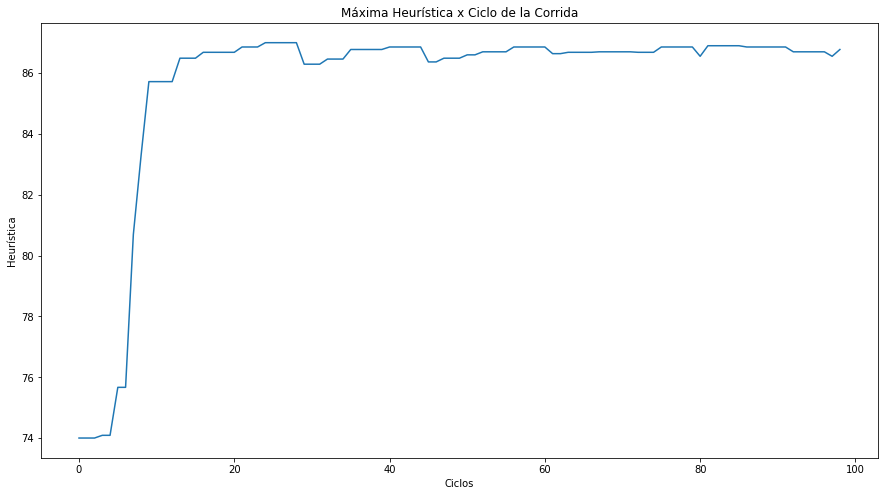

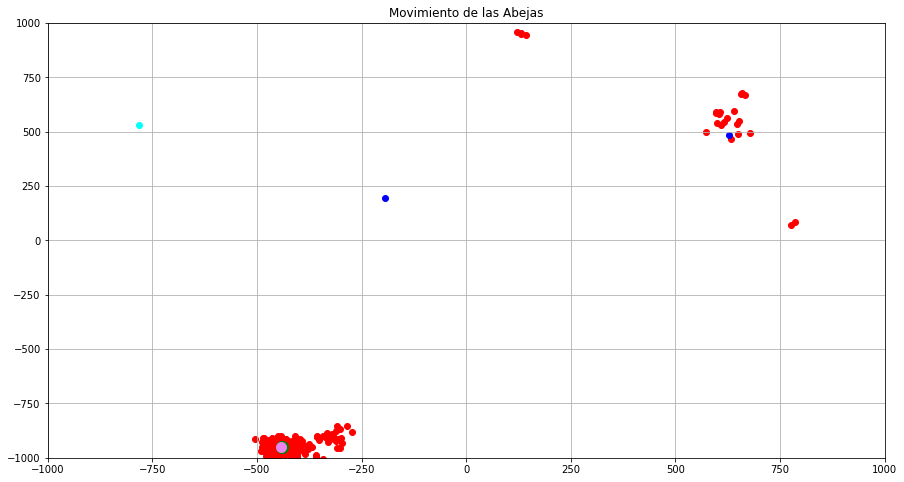

In [18]:
## MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8)) 
plt.plot(ciclosMaxAptitud)
plt.title('Máxima Heurística x Ciclo de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Heurística')
plt.show()


## MOSTRAR GRAFICO DEL MOVIMIENTO DE LAS ABEJAS
plt.figure(figsize=(15,8)) 

## --en Rojo: posiciones de las ABEJASde cada ciclo
for bee in ciclosAbejas:
  plt.scatter(bee[0], bee[1], color='red')

## -- en Azul: Máximos Locales (positivos)
## -- en Cyan: Mínimos Locales (negativos)
## -- en Verde: Máximo Óptimo
for posi, vali in zip(mapa.posMaximos, mapa.valMaximos):    
  if vali < 0:
      plt.scatter(posi[0], posi[1], color='cyan')
  else:
      plt.scatter(posi[0], posi[1], color='blue')
plt.scatter(mapa.posMaximoGlobal[0], mapa.posMaximoGlobal[1], color='green', s=150)      

## --en Violeta: Mejor posición de las partículas
plt.scatter(mejorAbeja.posicion[0], mejorAbeja.posicion[1], color='violet', s=100)

plt.title('Movimiento de las Abejas')
plt.xlim(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ)
plt.ylim(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ)
plt.grid(True)
plt.show()
